In [43]:
import ccxt
import time
import logging
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from datetime import timedelta, datetime
from utils import from_exchange_to_standard_notation, from_standard_to_exchange_notation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings


plt.rcParams['figure.figsize'] = 15,10
warnings.filterwarnings('ignore')

In [15]:
quotes_data = pd.read_csv('20190701.csv.gz')
trades_data = pd.read_csv('data/tick_data/20190701.csv.gz')

In [24]:
btc_trade_data = trades_data[trades_data.symbol == 'XBTUSD']
btc_trade_data['time'] = btc_trade_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
btc_trade_data.set_index('time', inplace=True)

btc_quotes_data = quotes_data[quotes_data.symbol == 'XBTUSD']
btc_quotes_data['time'] = btc_quotes_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
btc_quotes_data.set_index('time', inplace=True)

In [35]:
class OrderBookBarSeries(BarSeries):
    def __init__(self, quotes, ticks, datetimecolumn='time'):
        self.quotes = quotes
        self.ticks = ticks
        self.datetimecolumn = datetimecolumn

    def process_column(self, column_name, frequency):
        return self.ticks[column_name].resample(frequency, label='right').ohlc()

    def process_volume(self, column_name, frequency):
        return self.ticks[column_name].resample(frequency, label='right').sum()

    def process_ofi(self, frequency):
        quotes_df = self.quotes.copy().reset_index()
        quotes_df['midprice'] = ((quotes_df['bidPrice'] + quotes_df['askPrice']) / 2)
        quotes_df['midprice_returns'] = quotes_df['midprice'].diff()
        quotes_df['prevBidPrice'] = quotes_df['bidPrice'].shift()
        quotes_df['prevBidSize'] = quotes_df['bidSize'].shift()
        quotes_df['prevAskPrice'] = quotes_df['askPrice'].shift()
        quotes_df['prevAskSize'] = quotes_df['askSize'].shift()

        quotes_df.dropna(inplace=True)
        bid_geq = quotes_df['bidPrice'] >= quotes_df['prevBidPrice']
        bid_leq = quotes_df['bidPrice'] <= quotes_df['prevBidPrice']
        ask_geq = quotes_df['askPrice'] >= quotes_df['prevAskPrice']
        ask_leq = quotes_df['askPrice'] <= quotes_df['prevAskPrice']

        quotes_df['ofi'] = pd.Series(np.zeros(len(quotes_df)))
        quotes_df['ofi'].loc[bid_geq] += quotes_df['bidSize'].loc[bid_geq]
        quotes_df['ofi'].loc[bid_leq] -= quotes_df['prevBidSize'].loc[bid_leq]
        quotes_df['ofi'].loc[ask_geq] += quotes_df['prevAskSize'][ask_geq]
        quotes_df['ofi'].loc[ask_leq] -= quotes_df['askSize'][ask_leq]

        quotes_df = quotes_df.set_index('time')
        quotes_df = quotes_df[['midprice_returns','ofi']].resample(frequency).sum().dropna()
        return quotes_df

    def process_tfi(self, frequency):
        trades_df = self.ticks.copy()
        trades_df['signed_size'] = np.where(trades_df['side'] == 'Buy', trades_df['size'], -trades_df['size'])
        tfi = trades_df['signed_size'].resample(frequency).sum().dropna()
        return tfi

    def process_ticks(self, price_column='price', volume_column='size', frequency='5T'):
        price_df = self.process_column(price_column, frequency)
        volume_df = self.process_volume(volume_column, frequency)
        quotes_df = self.process_ofi(frequency)
        tfi = self.process_tfi(frequency)

        price_df['volume'] = volume_df
        price_df['ofi'] = quotes_df['ofi']
        price_df['tfi'] = tfi
        price_df['midprice_returns'] = quotes_df['midprice_returns']

        return price_df
    


In [36]:
orderbook_bars = OrderBookBarSeries(btc_quotes_data, btc_trade_data).process_ticks()

In [47]:
orderbook_bars = orderbook_bars.dropna()

In [53]:
def plot_ofi_and_ols_summary(df, dt):
    df.plot(kind='scatter', grid=True, 
                            x='ofi', y='midprice_returns', 
                            title = 'XBTUSD '+ dt + ' OFI',
                            alpha=0.5, figsize=(12,10))
    ofi_ = sm.add_constant(df['ofi'])
    ols = sm.OLS(df['midprice_returns'], ofi_).fit()
    print(ols.summary2())

In [54]:
def plot_tfi_and_ols_summary(tf, dmid, dt):
    pd.concat([tf,dmid], axis = 1).plot(kind='scatter', grid=True, 
                                        x='tfi', y='midprice_returns', 
                                        title = 'XBTUSD '+ dt + ' TFI', 
                                        alpha=0.5, figsize=(12,10))
    tf_ = sm.add_constant(tf)
    ols = sm.OLS(dmid, tf_).fit()
    print(ols.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.507    
Dependent Variable: midprice_returns AIC:                2821.1334
Date:               2019-08-05 02:30 BIC:                2828.4524
No. Observations:   287              Log-Likelihood:     -1408.6  
Df Model:           1                F-statistic:        294.9    
Df Residuals:       285              Prob (F-statistic): 7.13e-46 
R-squared:          0.509            Scale:              1080.2   
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const       -1.5604     1.9411   -0.8039   0.4221   -5.3810   2.2603
ofi          0.0000     0.0000   17.1737   0.0000    0.0000   0.0000
------------------------------------------------------------------
Omnibus:             48.918       Durbin-Watson:          1.559   
Pro

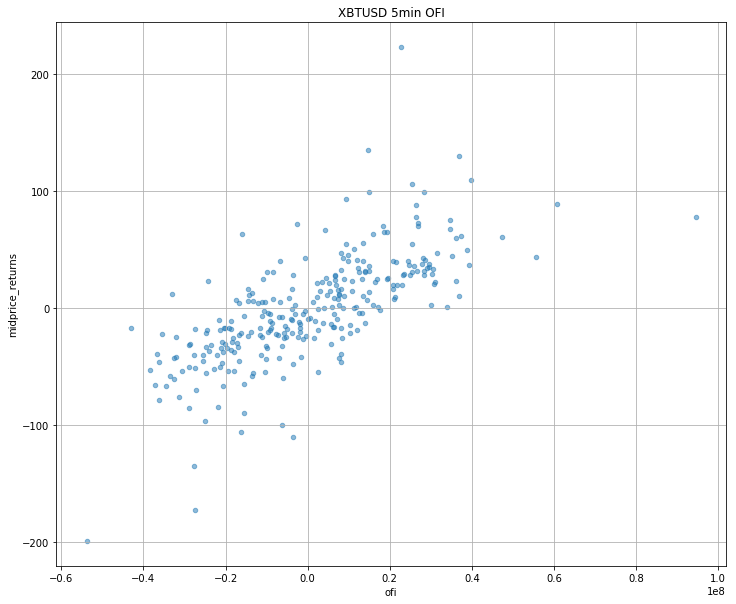

In [56]:
tfi = orderbook_bars['tfi']
returns = orderbook_bars['midprice_returns']
plot_ofi_and_ols_summary(orderbook_bars, '5min')

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.668    
Dependent Variable: midprice_returns AIC:                2707.9620
Date:               2019-08-05 02:30 BIC:                2715.2810
No. Observations:   287              Log-Likelihood:     -1352.0  
Df Model:           1                F-statistic:        575.3    
Df Residuals:       285              Prob (F-statistic): 2.46e-70 
R-squared:          0.669            Scale:              728.21   
---------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
---------------------------------------------------------------------
const    1.5235      1.5951     0.9551    0.3403    -1.6162    4.6631
tfi      0.0000      0.0000    23.9847    0.0000     0.0000    0.0000
------------------------------------------------------------------
Omnibus:              87.166       Durbin-Watson:          2.023 

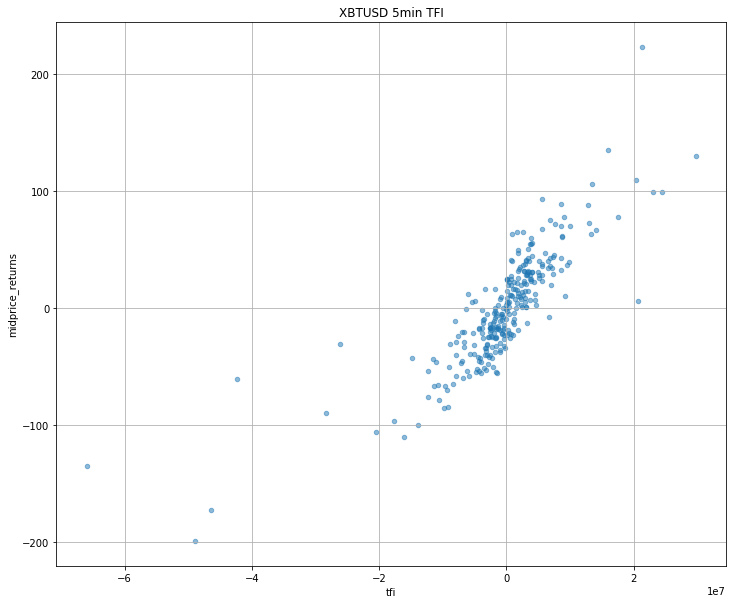

In [57]:
plot_tfi_and_ols_summary(tfi, returns, '5min')